# Train

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
    
def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
#          L1 regularizer
    with torch.enable_grad():
        reg = 1e-02
        l1_loss = torch.zeros(1)
        for name, param in cl.named_parameters():
            if 'bias' not in name:  # param is a weight tensor
                l1_loss += reg*torch.sum(torch.abs(param))
    err += l1_loss.item()
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

In [29]:
def make_classifier(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # Make a classifier wrapper!
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(min_, max_),
        loss=criterion,
        optimizer=optimizer,
        input_shape=(1, 28, 28),
        nb_classes=10,
    )
    return classifier



def adversarial_training(model, device, data, epsilon):
    dim = data.size()
    batch = torch.Tensor()
    fgsm = np.random.choice([0, 1], size=dim[0], p=[0, 1])
    for image, is_fgsm in zip(data, fgsm):
        # VIP Reshape image for model compatibility
        image = image.view(1, dim[1], dim[2], dim[3])
        image, batch = image.to(device), batch.to(device)
        if is_fgsm:
            classifier = make_classifier(model)
            adv_crafter = FastGradientMethod(classifier, eps=epsilon)
            perturbed_image = adv_crafter.generate(x=image.cpu().detach().numpy())
            batch = torch.cat((batch, torch.Tensor(perturbed_image).to(device)), dim=0)
        else:
            batch = torch.cat((batch, image), dim=0)
    return batch

In [30]:
num_epochs = 4
e_losses = []
# Load pre-trained model
cl = Classifier().to(device)

# optimizer
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cl.parameters(), lr=0.01, momentum=0.5)

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  
        new_batch = adversarial_training(cl, device, data, epsilon=.3)
        c_error,c_pred = train_classifier(cl,cl_opt, new_batch.to(device), target.to(device)) 
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_dataloader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_dataloader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

Epoch  0 : Test accuracy:  94.32000000000001 %
Epoch  1 : Test accuracy:  96.16 %
Epoch  2 : Test accuracy:  96.89 %
Epoch  3 : Test accuracy:  97.24000000000001 %
Performance in the trained model: 
Test accuracy:  97.24000000000001 %
FINISHED!!!


In [31]:
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/FGSM Adversarial/regularised")
file = "L1_1e-02.pth"
torch.save(cl.state_dict(), os.path.join(path, file))

# Attack

In [21]:
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/FGSM Adversarial/regularised")
file = "L1_1e-05.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

In [22]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 97.19 %


In [23]:
accuracies = []

# Run test for each epsilon
for e in epsilons:
    adv_crafter = FastGradientMethod(classifier, eps=e)
    x_test_adv = adv_crafter.generate(x=x_test)
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    accuracies.append(accuracy)
    print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))
    
print(accuracies)

Epsilon: 0.001   Test Accuracy = 0.9716
Epsilon: 0.05   Test Accuracy = 0.9622
Epsilon: 0.1   Test Accuracy = 0.9424
Epsilon: 0.15   Test Accuracy = 0.9128
Epsilon: 0.2   Test Accuracy = 0.8692
Epsilon: 0.25   Test Accuracy = 0.8154
Epsilon: 0.3   Test Accuracy = 0.7515
[0.9716, 0.9622, 0.9424, 0.9128, 0.8692, 0.8154, 0.7515]


## Results

### L1

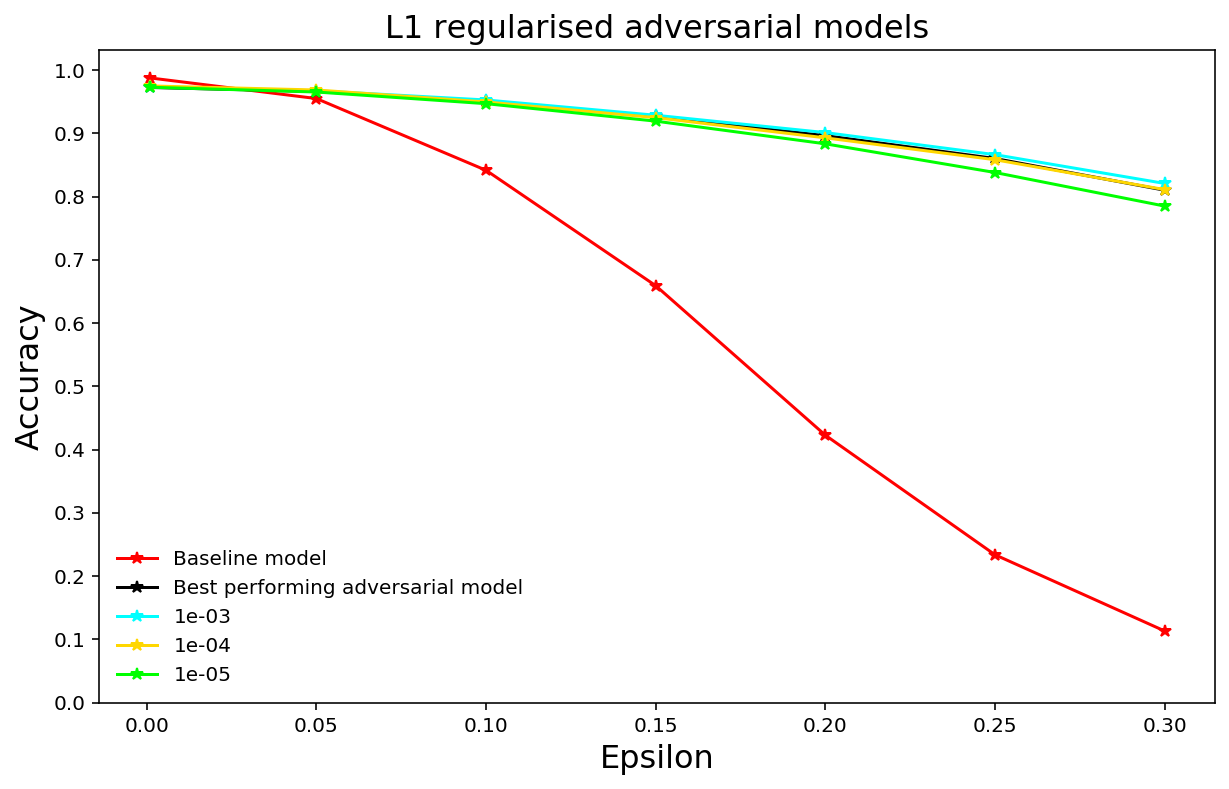

In [6]:
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'Baseline model': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    'Best performing adversarial model': [0.97245, 0.96605, 0.95085, 0.92695, 0.89625, 0.86015, 0.81],
    '1e-03': [0.9732 , 0.96725, 0.95265, 0.9285 , 0.9011 , 0.8662 , 0.8207 ],
    '1e-04': [0.97485, 0.96845, 0.94955, 0.9247 , 0.8928 , 0.8582 , 0.81095],
    '1e-05': [0.9728 , 0.96525, 0.9468 , 0.9192 , 0.88335, 0.838  , 0.7849 ],

}

n = len(results)
colors = pl.cm.gnuplot(np.linspace(0,0.55,n))

colors = ['red', 'black', 'cyan', 'gold', 'lime']

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("L1 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()

### L2

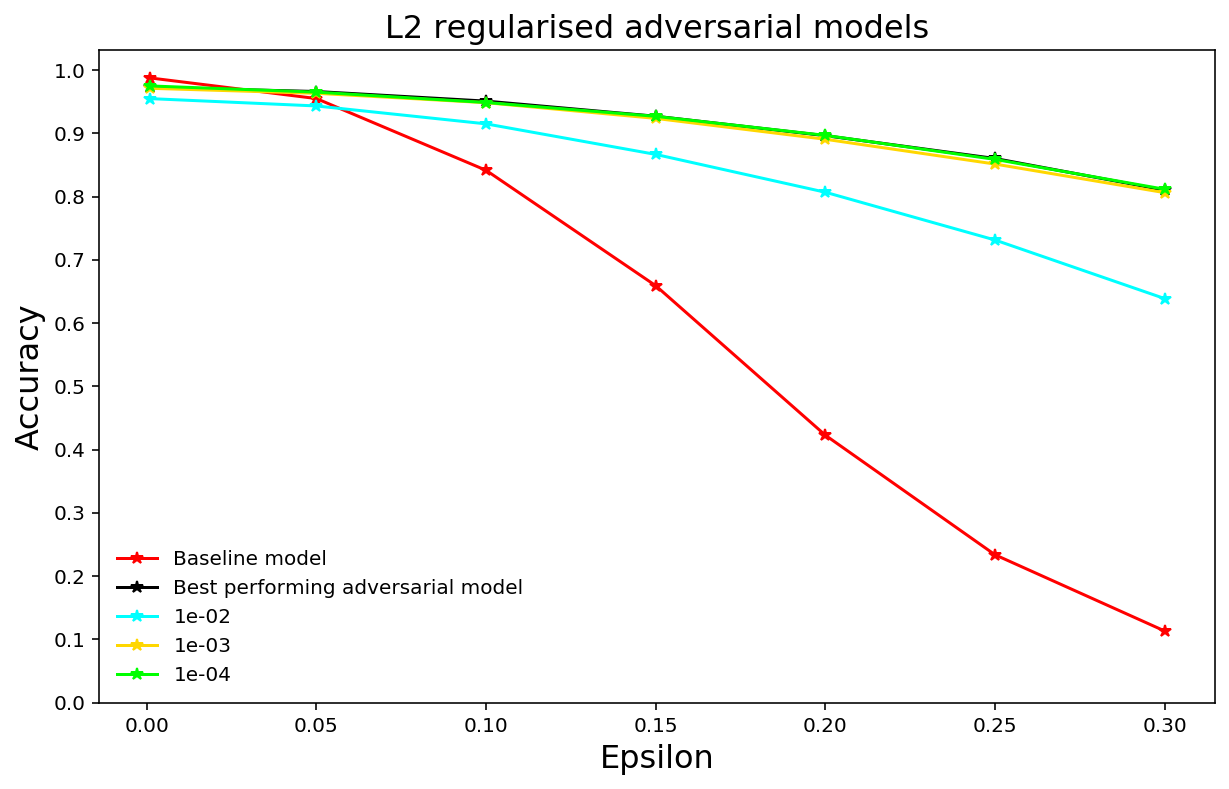

In [4]:
epsilons = [0.001, .05, .1, .15, .2, .25, .3]
results = {
    'Baseline model': [0.9875, 0.9549, 0.8415, 0.6591, 0.4227, 0.2337, 0.1132],
    'Best performing adversarial model': [0.97245, 0.96605, 0.95085, 0.92695, 0.89625, 0.86015, 0.81],
    '1e-02': [0.9548, 0.9432, 0.9149, 0.8666, 0.8068, 0.7313, 0.6387],
    '1e-03': [0.9711 , 0.9632 , 0.94835, 0.92355, 0.89055, 0.85135, 0.80615],
    '1e-04': [0.97485, 0.96505, 0.94865, 0.9268 , 0.8967 , 0.85875, 0.8115 ],

}

n = len(results)
colors = pl.cm.gnuplot(np.linspace(0,0.55,n))

colors = ['red', 'black', 'cyan', 'gold', 'lime']

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("L2 regularised adversarial models",fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='lower left', frameon=False)
plt.show()